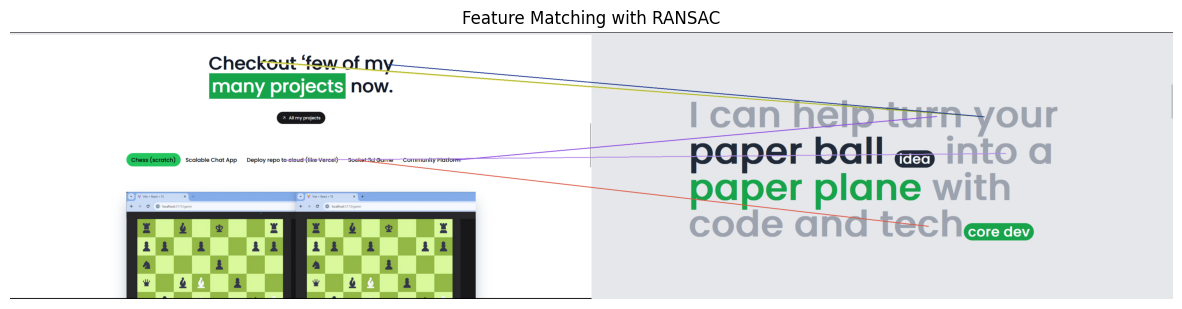

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load the color images
img1_color = cv2.imread('left.png') # Query image (color)
img2_color = cv2.imread('right.png') # Train image (color)
# Convert to grayscale for feature detection
img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)
# Initialize SIFT detector
sift = cv2.SIFT_create()
# Detect keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
# FLANN parameters and matcher setup
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
# Match descriptors using KNN
matches = flann.knnMatch(des1, des2, k=2)
# Ratio test to keep good matches
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)
# Extract location of good matches
points1 = np.zeros((len(good), 2), dtype=np.float32)
points2 = np.zeros((len(good), 2), dtype=np.float32)
for i, match in enumerate(good):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt
# Find homography using RANSAC
H, status = cv2.findHomography(points1, points2, cv2.RANSAC)
# Create a new image that puts the two images side by side
height = max(img1_color.shape[0], img2_color.shape[0])
width = img1_color.shape[1] + img2_color.shape[1]
output = np.zeros((height, width, 3), dtype=np.uint8)
# Place both images within this new image
output[0:img1_color.shape[0], 0:img1_color.shape[1]] = img1_color
output[0:img2_color.shape[0], img1_color.shape[1]:img1_color.shape[1]+img2_color.shape[1]] = img2_color
# Draw lines between the matching points
for i, (m, color) in enumerate(zip(good, np.random.randint(0, 255, (len(good), 3)))):
    if status[i]:
        pt1 = tuple(map(int, kp1[m.queryIdx].pt))
        pt2 = tuple(map(int, kp2[m.trainIdx].pt))
        pt2 = (pt2[0] + img1_color.shape[1], pt2[1]) # Shift the point for img2
        cv2.line(output, pt1, pt2, color.tolist(), 2)
# Convert the result to RGB for matplotlib display and show the final image
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
# Use matplotlib to display the image
plt.figure(figsize=(15, 5))
plt.imshow(output_rgb)
plt.axis('off') # Turn off axis numbers and ticks
plt.title('Feature Matching with RANSAC')
plt.show()